In [41]:
import os
import tensorflow as tf
#load compressed models from tensorflow hub
os.environ['TFHUB_MODEL_LOAD_FORMAT']='COMPRESSED'

In [42]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [43]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] ==1 
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [44]:
# fullPath1 = os.path.abspath("./images/Elevator.jpg") 
# fullPath2 = os.path.abspath("./images/rembrandt.jpg")  
# content_path = tf.keras.utils.get_file('Elevator.jpg', 'file://'+ fullPath1)
# style_path = tf.keras.utils.get_file('rembrandt.jpg','file://'+ fullPath2)
content_path = './images/Elevator.jpg'
style_path = './images/durer.jpg'


In [45]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape= tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

    
    

In [46]:
def imshow(image, title=None):
    if len(image.shape)>3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

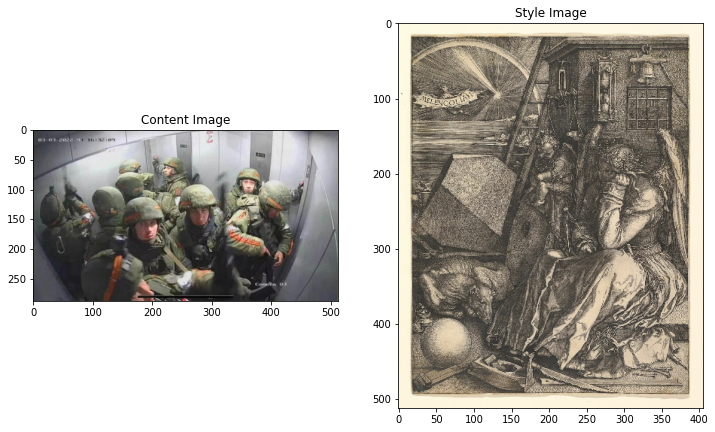

In [47]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


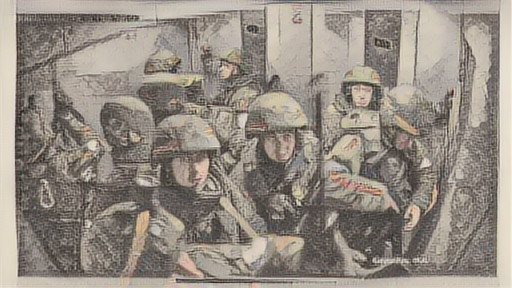

In [48]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [49]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x,(224, 224))
vgg = tf.keras.applications.VGG19( include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [50]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('bobsled', 0.24238266),
 ('military_uniform', 0.11639694),
 ('projectile', 0.05149639),
 ('shield', 0.039945472),
 ('breastplate', 0.031612884)]

In [51]:
vgg = tf.keras.applications.VGG19(include_top = False, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [52]:
content_layers = ['block5_conv2'] 

style_layers = [
                
           
                'block1_conv2', 
                'block2_conv2',
                'block3_conv3',
                'block5_conv3',
                'block4_conv3',
                 
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [53]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [54]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv2
  shape:  (1, 512, 405, 64)
  min:  0.0
  max:  2204.8813
  mean:  164.16583

block2_conv2
  shape:  (1, 256, 202, 128)
  min:  0.0
  max:  7316.2246
  mean:  153.37111

block3_conv3
  shape:  (1, 128, 101, 256)
  min:  0.0
  max:  6252.7295
  mean:  434.66788

block5_conv3
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  471.24338
  mean:  7.4668474

block4_conv3
  shape:  (1, 64, 50, 512)
  min:  0.0
  max:  9432.076
  mean:  189.73428



In [55]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [56]:
class StyleContentModel(tf.keras.models.Model):
     def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

     def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

        content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [57]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv2
    shape:  (1, 64, 64)
    min:  71.11268
    max:  167358.67
    mean:  6950.461

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.121656574
    max:  130223.28
    mean:  9691.208

   block3_conv3
    shape:  (1, 256, 256)
    min:  2254.232
    max:  620360.75
    mean:  83127.29

   block4_conv3
    shape:  (1, 512, 512)
    min:  0.0
    max:  761333.3
    mean:  29679.86

   block5_conv3
    shape:  (1, 512, 512)
    min:  0.0
    max:  4927.4126
    mean:  69.60834

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1860.9247
    mean:  17.698538


In [58]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [59]:
image = tf.Variable(content_image)

In [60]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [61]:
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1=0.99,  epsilon = 1e-1)

In [62]:
style_weight = 1e-2
content_weight=1e4

In [63]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [64]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

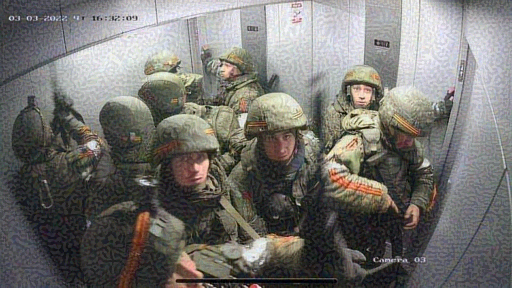

In [65]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

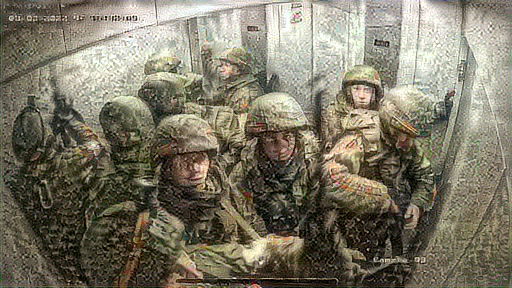

train step: 50
total time : 128.9


In [66]:
import time 
start = time.time()

epochs = 10
steps_per_epoch = 5

step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        train_step(image)
        print(".", end='', flush=True)
        display.clear_output(wait = True)
        display.display(tensor_to_image(image))
        print('train step: {}'.format(step))
    end = time.time()
    print("total time : {:.1f}".format(end-start))

In [67]:
def high_pass_x_y(image):
    x_var = image [:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :]- image[:, -1:, :, :]
    
    return x_var, y_var

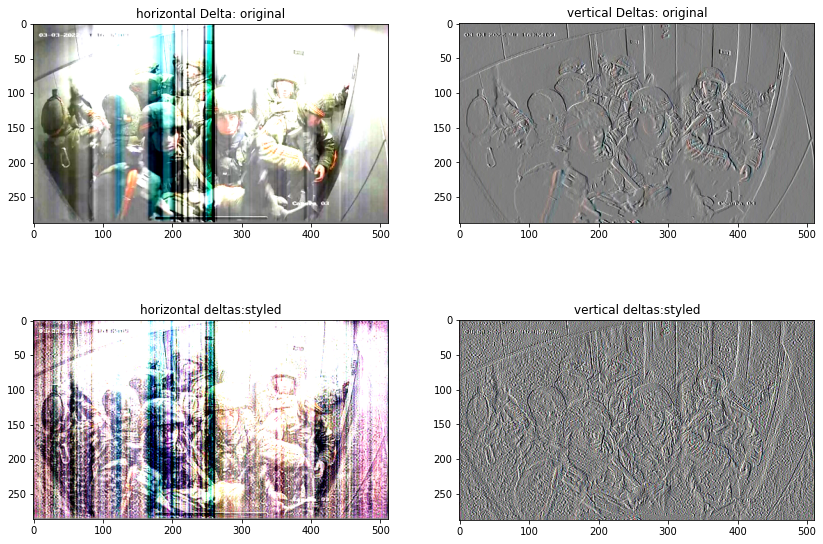

In [68]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "horizontal Delta: original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "vertical Deltas: original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "horizontal deltas:styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "vertical deltas:styled")

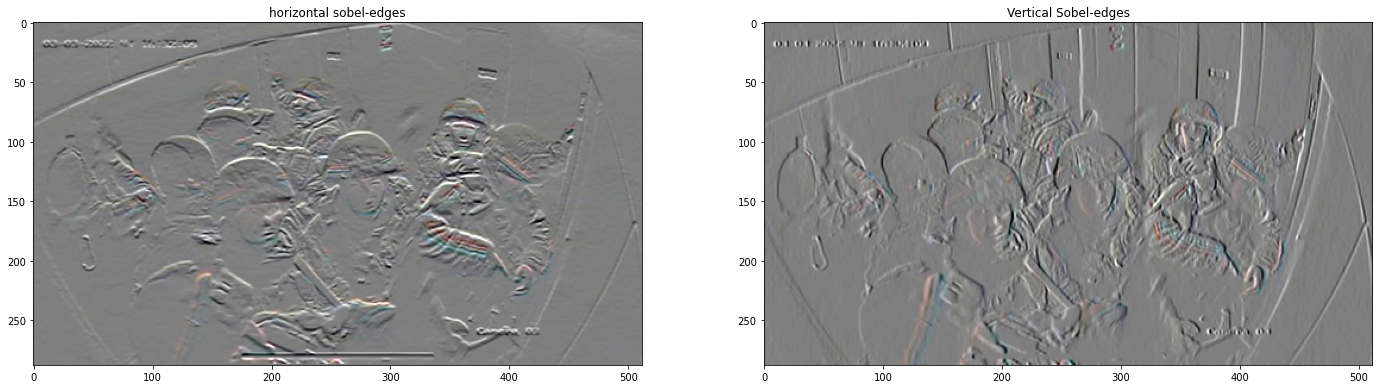

In [69]:
plt.figure(figsize=(24, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "horizontal sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [70]:
def total_variation_loss(image):
      x_deltas, y_deltas = high_pass_x_y(image)
      return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [71]:
total_variation_loss(image).numpy()

165882.81

In [72]:
total_variation_weight = 30 

In [73]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor ( image )
        loss = style_content_loss(outputs)
        loss +=total_variation_weight*tf.image.total_variation(image)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])    
    image.assign(clip_0_1(image))

In [74]:
image = tf.Variable(content_image)

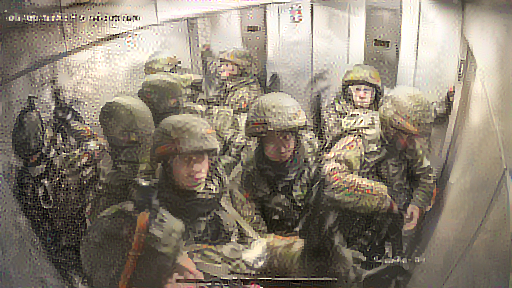

Train step: 400
total time:1200.0


In [75]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 40

step = 0
for n in range(epochs):
    for m in range (steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end = " ", flush = True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    
end = time.time()
print("total time:{:.1f}".format(end-start))        